In [19]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as speech_recog
import openai
from tensorflow.keras.models import load_model
import pyaudio
import librosa
import torch
from tqdm import tqdm  
from transformers import AutoModelForCausalLM, AutoTokenizer
import simpleaudio as sa
import sounddevice as sd

In [ ]:
data_paths = {
    "노인남녀": "/Users/yudayeon/Library/Mobile Documents/com~apple~CloudDocs/음성 test 3gb/노인 남녀",
    "소아유아": "/Users/yudayeon/Library/Mobile Documents/com~apple~CloudDocs/음성 test 3gb/소아, 유아",
    "일반남녀": "/Users/yudayeon/Library/Mobile Documents/com~apple~CloudDocs/음성 test 3gb/일반 남녀"
}

In [5]:
label_map = {"노인남녀": 0, "소아유아": 1, "일반남녀": 2}

In [6]:
# 데이터 로드와 레이블 저장을 동시에 처리하는 함수

def load_data_with_labels(data_paths, label_map, sr=16000, n_mels=64, max_len=100):
    features = []
    labels = []
    
    for label_name, folder_path in data_paths.items():
        print(f"Processing folder: {folder_path} (Label: {label_name})")
        for root, dirs, files in tqdm(os.walk(folder_path), desc=f"Loading {label_name}"):
            for file_name in files:
                if file_name.lower().endswith('.wav'):  
                    file_path = os.path.join(root, file_name)
                    try:
                        
                        y, _ = librosa.load(file_path, sr=sr)
                        
                        
                        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
                        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                        
                        
                        if mel_spec_db.shape[1] > max_len:
                            mel_spec_db = mel_spec_db[:, :max_len]
                        else:
                            pad_width = max_len - mel_spec_db.shape[1]
                            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
                        
                        
                        features.append(mel_spec_db)
                        labels.append(label_map[label_name])
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    
    return np.array(features), np.array(labels)

features, labels = load_data_with_labels(data_paths, label_map)


print(f"Features shape: {features.shape}")  
print(f"Labels shape: {labels.shape}")     

Processing folder: /Users/yudayeon/Library/Mobile Documents/com~apple~CloudDocs/음성 test 3gb/노인 남녀 (Label: 노인남녀)


Loading 노인남녀: 9it [01:27,  9.69s/it]


Processing folder: /Users/yudayeon/Library/Mobile Documents/com~apple~CloudDocs/음성 test 3gb/소아, 유아 (Label: 소아유아)


Loading 소아유아: 5it [00:47,  9.42s/it]


Processing folder: /Users/yudayeon/Library/Mobile Documents/com~apple~CloudDocs/음성 test 3gb/일반 남녀 (Label: 일반남녀)


Loading 일반남녀: 23it [01:03,  2.78s/it]


Features shape: (23098, 64, 100)
Labels shape: (23098,)


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print("Train features shape:", X_train.shape)  
print("Test features shape:", X_test.shape)
print("Train labels distribution:", np.bincount(y_train))
print("Test labels distribution:", np.bincount(y_test))


class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)  # 채널 추가
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train features shape: (18478, 64, 100)
Test features shape: (4620, 64, 100)
Train labels distribution: [6385 5417 6676]
Test labels distribution: [1611 1355 1654]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, n_mels, max_len, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (n_mels // 4) * (max_len // 4), 128)  # Flatten 후 크기 계산
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

n_mels = 64
max_len = 100      
num_classes = len(label_map)


model = SimpleCNN(n_mels=n_mels, max_len=max_len, num_classes=num_classes)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [10]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.8986
Epoch 2/10, Loss: 0.1774
Epoch 3/10, Loss: 0.1067
Epoch 4/10, Loss: 0.0667
Epoch 5/10, Loss: 0.0400
Epoch 6/10, Loss: 0.0234
Epoch 7/10, Loss: 0.0272
Epoch 8/10, Loss: 0.0835
Epoch 9/10, Loss: 0.0299
Epoch 10/10, Loss: 0.0139


In [139]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

   
    overall_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")

    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        true_positive = np.sum((np.array(all_preds) == i) & (np.array(all_labels) == i))
        total_samples = np.sum(np.array(all_labels) == i)
        class_accuracies[class_name] = 100 * true_positive / total_samples if total_samples > 0 else 0.0

    print("\nClass-wise Accuracy:")
    for class_name, accuracy in class_accuracies.items():
        print(f"{class_name}: {accuracy:.2f}%")
    
    # 컨퓨전 매트릭스
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    return cm, class_accuracies

class_names = ["노인", "소아", "일반"]

cm, class_accuracies = evaluate_model_with_metrics(model, test_loader, class_names)


Overall Accuracy: 98.85%

Class-wise Accuracy:
노인: 99.81%
소아: 98.45%
일반: 98.25%

Confusion Matrix:
[[1608    1    2]
 [   8 1334   13]
 [   6   23 1625]]

Classification Report:
              precision    recall  f1-score   support

          노인       0.99      1.00      0.99      1611
          소아       0.98      0.98      0.98      1355
          일반       0.99      0.98      0.99      1654

    accuracy                           0.99      4620
   macro avg       0.99      0.99      0.99      4620
weighted avg       0.99      0.99      0.99      4620



/opt/anaconda3/envs/voice_env/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/voice_env/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/voice_env/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/voice_env/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/voice_env/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/voice_env/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48152 (\N{HANGUL SYLLAB

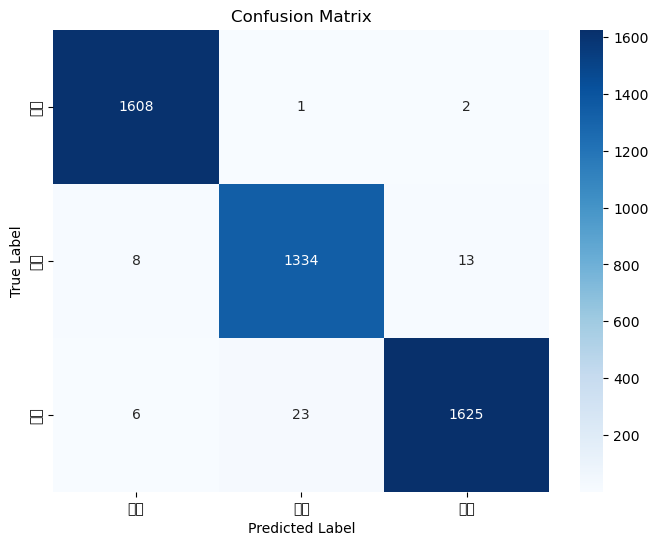

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 컨퓨전 매트릭스 시각화
plot_confusion_matrix(cm, class_names)


In [146]:
import csv

def save_results_to_csv(results, filename="results.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Predicted", "Actual"])
        writer.writerows(results)

save_results_to_csv(results, filename="/Users/yudayeon/Downloads/results.csv")

In [13]:
torch.save(model.state_dict(), "cnn_model.pth")

In [ ]:
#api연결하기

In [ ]:
import sounddevice as sd
sd.default.device = 2  

음성을 입력하세요 (10초 동안 녹음):
녹음 완료. 음성을 처리 중입니다...
입력된 음성을 재생합니다...


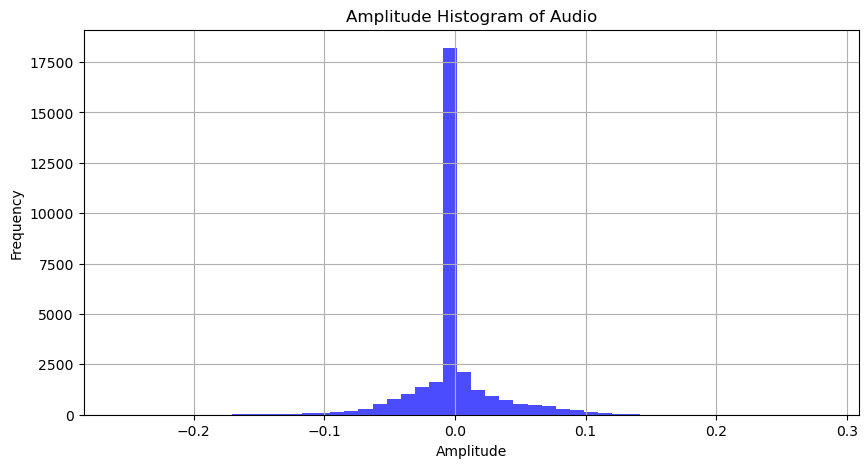

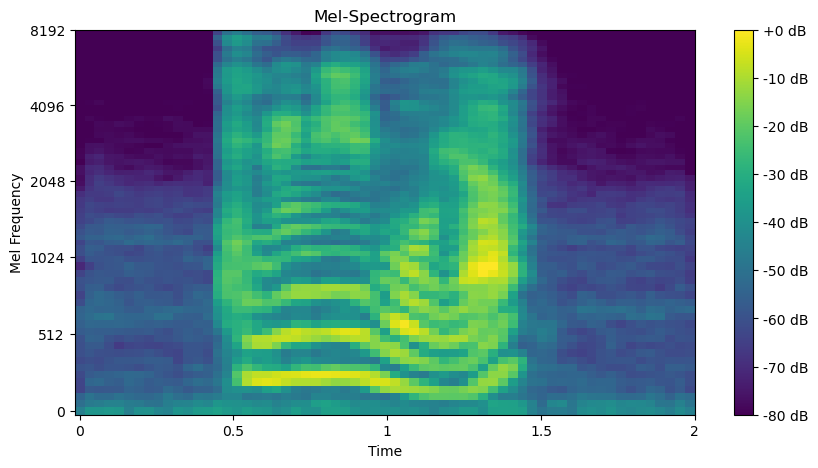

예측된 연령대: 1


In [137]:
import matplotlib.pyplot as plt

# 음성 데이터 시각화: 히스토그램 및 멜스펙트로그램 생성 함수
def visualize_audio_data(audio_wav, sr):
    # 1. 히스토그램 생성
    plt.figure(figsize=(10, 5))
    plt.hist(audio_wav, bins=50, color='blue', alpha=0.7)
    plt.title('Amplitude Histogram of Audio')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # 2. Mel-Spectrogram 시각화
    mel_spec = librosa.feature.melspectrogram(y=audio_wav, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.show()

# 실시간 음성 입력 처리 함수 수정 (히스토그램 및 멜스펙트로그램 추가)
def process_voice_input():
    recognizer = speech_recog.Recognizer()
    sr = 16000  

    try:
        with speech_recog.Microphone(sample_rate=sr) as source:  
            print("음성을 입력하세요 (10초 동안 녹음):")
            audio_data = recognizer.listen(source, timeout=10)
            print("녹음 완료. 음성을 처리 중입니다...")

            audio_wav = np.frombuffer(audio_data.get_raw_data(), dtype=np.int16).astype(np.float32) / 32768.0
            print("입력된 음성을 재생합니다...")
            play_audio(audio_wav, sr)

            visualize_audio_data(audio_wav, sr)

            # Mel-Spectrogram 생성
            mel_spec = librosa.feature.melspectrogram(y=audio_wav, sr=sr, n_mels=n_mels)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # 패딩 또는 자르기로 크기 통일
            max_len = 100
            if mel_spec_db.shape[1] > max_len:
                mel_spec_db = mel_spec_db[:, :max_len]
            else:
                pad_width = max_len - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')

            # 모델 입력 형태로 변환
            input_tensor = torch.tensor(mel_spec_db).unsqueeze(0).unsqueeze(0)

            # 연령대 예측
            with torch.no_grad():
                outputs = model(input_tensor)
                predicted_label = torch.argmax(outputs, dim=1).item()

            print(f"예측된 연령대: {predicted_label}")
    except Exception as e:
        print(f"오류 발생: {e}")

# 실행
process_voice_input()


In [46]:
"sk-proj-EUvpJGZ9f1smtnXxzHd71pFfcqfU860OpK16gx4E9R8-"

1.55.0


In [16]:
import sounddevice as sd
sd.default.device = 2  

In [145]:
import torch
import openai
import speech_recognition as speech_recog
import librosa
import numpy as np
from gtts import gTTS
import os
from pydub import AudioSegment
from pydub.playback import play

# OpenAI API 키 설정, 개인 api키를 올릴 수 없어서 변경하였습니다
openai.api_key = "sk-proj-EUvpJGZ9f1smtnXxzHd71pFfcqfU860OpK16gx4E9R8-EOJXGoxPTWi1-"

# CNN 모델 클래스
class SimpleCNN(torch.nn.Module):
    def __init__(self, n_mels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 16 * 25, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 초기화 및 로드
n_mels = 64
num_classes = 3
model = SimpleCNN(n_mels=n_mels, num_classes=num_classes)
model.load_state_dict(torch.load("cnn_model.pth", weights_only=True))
model.eval()

# GPT 응답 함수
def get_gpt_response(prompt, predicted_label):
    tone_prompts = {
        0: "나이가 있으신 분께 공손하고 느린 어조로 쉽게 설명해주세요.",
        1: "어린이가 이해할 수 있도록 친근하고 재미있게 설명해주세요.",
        2: "일반 성인을 대상으로 명확하고 간결하게 설명해주세요."
    }
    tone_prompt = tone_prompts.get(predicted_label, "일반적으로 답변해주세요.")
    full_prompt = f"{prompt} {tone_prompt}"
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": full_prompt}
            ],
            max_tokens=300,
            temperature=0.7
        )
        return response['choices'][0]['message']['content']
    except Exception as e:
        print(f"GPT API 호출 에러: {e}")
        return "죄송합니다. 답변을 생성하는 데 문제가 발생했습니다."

# gTTS로 음성 출력 함수
def play_korean_tts(text, predicted_label):
    try:
        tts = gTTS(text=text, lang='ko')
        tts.save("response.mp3")
        
        # 음성을 librosa로 로드
        y, sr = librosa.load("response.mp3", sr=None)
        
        if predicted_label == 0:  # 나이가 있으신 분
            y = librosa.effects.time_stretch(y, rate=0.8)  # 느리게
            y = y * 1.5  # 볼륨을 1.5배 증가
        elif predicted_label == 1:  # 어린이
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)  # 피치 높이기
            y = librosa.effects.time_stretch(y, rate=1.2)  # 속도를 빠르게
        elif predicted_label == 2:  # 일반 성인
            y = librosa.effects.time_stretch(y, rate=1.1)  # 속도를 약간 빠르게

        # 수정된 음성을 저장
        sf.write("response_modified.wav", y, sr)

        # `pydub`로 파일 로드 및 재생
        sound = AudioSegment.from_file("response_modified.wav", format="wav")

        if predicted_label == 0:  # 나이가 있으신 분
            sound = sound.apply_gain(+5)  # 볼륨을 추가로 증가 (pydub로)
        
        play(sound)
    except Exception as e:
        print(f"TTS 생성 오류: {e}")

# 실시간 음성 입력 처리 함수
def process_voice_input():
    recognizer = speech_recog.Recognizer()
    sr = 16000  # 샘플링 속도
    try:
        with speech_recog.Microphone(sample_rate=sr) as source:
            print("음성을 입력하세요 (10초 동안 녹음):")
            audio_data = recognizer.listen(source, timeout=10)
            print("녹음 완료. 음성을 처리 중입니다...")
            
            # Mel-Spectrogram 생성
            audio_wav = np.frombuffer(audio_data.get_raw_data(), dtype=np.int16).astype(np.float32) / 32768.0
            mel_spec = librosa.feature.melspectrogram(y=audio_wav, sr=sr, n_mels=n_mels)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # 패딩 또는 자르기로 크기 통일
            max_len = 100
            if mel_spec_db.shape[1] > max_len:
                mel_spec_db = mel_spec_db[:, :max_len]
            else:
                pad_width = max_len - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')

            # 모델 입력 형태로 변환
            input_tensor = torch.tensor(mel_spec_db).unsqueeze(0).unsqueeze(0)

            # 연령대 예측
            with torch.no_grad():
                outputs = model(input_tensor)
                predicted_label = torch.argmax(outputs, dim=1).item()
            print(f"예측된 연령대: {predicted_label}")

            # 음성을 텍스트로 변환
            try:
                text = recognizer.recognize_google(audio_data, language="ko-KR")
                print(f"변환된 텍스트: {text}")
            except Exception as e:
                print(f"음성 변환 오류: {e}")
                return

            # GPT 응답 생성 및 출력
            response = get_gpt_response(text, predicted_label)
            print(f"GPT 응답: {response}")
            play_korean_tts(response, predicted_label)
    except Exception as e:
        print(f"오류 발생: {e}")

# 실행
if __name__ == "__main__":
    process_voice_input()


음성을 입력하세요 (10초 동안 녹음):
녹음 완료. 음성을 처리 중입니다...
예측된 연령대: 1
변환된 텍스트: 구름이 뭐야
GPT 응답: 구름은 하늘에 떠다니는 크고 푹신한 모래알같은 것이야! 이 모래알들이 모이면 하늘에 큰 구름이 만들어지는 거야. 구름은 바람에 흔들리면서 모양을 바꾸기도 해. 가끔 구름이 물방울로 변해서 비를 내리기도 해! 하늘을 즐겁게 보면서 구름을 발견해보는 건 어때? 그리고 구름이 어떻게 만들어지는지도 궁금하다면 물어봐줘! 함께 알아보자!


In [99]:
import soundfile as sf

In [92]:
import torch
import torch.nn as nn
from torchviz import make_dot

# SimpleCNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, n_mels, max_len, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (n_mels // 4) * (max_len // 4), 128)  # Flatten 후 크기 계산
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


n_mels = 64
max_len = 100
num_classes = 3
model = SimpleCNN(n_mels=n_mels, max_len=max_len, num_classes=num_classes)

# 임의의 입력 데이터 생성
input_tensor = torch.randn(1, 1, n_mels, max_len)

# 모델 시각화
output = model(input_tensor)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_model_structure", format="png")  # 모델 구조를 PNG로 저장


'cnn_model_structure.png'